In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [163]:
ljubljana_weather = pd.read_csv("../ljubljana_vreme_daily_2010_2023.csv")

In [164]:
lj_accidents = pd.read_csv("../ljubljana_nesrece_2010_2023.csv")
# print(lj_accidents['NastanekDatumCas'].dtype)

In [165]:
# Pretvori stolpec 'NastanekDatumCas' v pravilen format (vsaka vrednost bo pandas objekt za datum in čas)
lj_accidents['NastanekDatumCas'] = pd.to_datetime(lj_accidents['NastanekDatumCas'], format='ISO8601', utc=True, errors='coerce')
lj_accidents['NastanekDatumCas'] = lj_accidents['NastanekDatumCas'].dt.tz_convert('Europe/Ljubljana')
# print(f"NastanekDatumCas column dtype: {lj_accidents['NastanekDatumCas'].dtype}")

ljubljana_weather['date'] = pd.to_datetime(ljubljana_weather['date'], format='ISO8601', errors='coerce')
ljubljana_weather['Datum'] = ljubljana_weather['date'].dt.date
# ljubljana_weather['date'] = ljubljana_weather['date'].dt.tz_convert('Europe/Ljubljana')
# print(f"Weather date column dtype: {ljubljana_weather['date'].dtype}")

# print(ljubljana_weather['date'].iloc[50])
# print(ljubljana_weather['date'].iloc[500])

# display(lj_accidents)
# display(ljubljana_weather)

#### Dodajanje stolpcev

In [166]:
day_translation = {
    'Monday': 'Ponedeljek',
    'Tuesday': 'Torek',
    'Wednesday': 'Sreda',
    'Thursday': 'Četrtek',
    'Friday': 'Petek',
    'Saturday': 'Sobota',
    'Sunday': 'Nedelja'
}
day_order_slo = ['Ponedeljek', 'Torek', 'Sreda', 'Četrtek', 'Petek', 'Sobota', 'Nedelja']

month_translation = {
    'January': 'Januar', 'February': 'Februar', 'March': 'Marec',
    'April': 'April', 'May': 'Maj', 'June': 'Junij',
    'July': 'Julij', 'August': 'Avgust', 'September': 'September',
    'October': 'Oktober', 'November': 'November', 'December': 'December'
}
month_order_slo = ['Januar', 'Februar', 'Marec', 'April', 'Maj', 'Junij', 'Julij', 'Avgust', 'September', 'Oktober', 'November', 'December']

lj_accidents['Day_EN'] = lj_accidents['NastanekDatumCas'].dt.day_name()
lj_accidents['Day_SLO'] = lj_accidents['Day_EN'].map(day_translation)

lj_accidents['Mesec_EN'] = lj_accidents['NastanekDatumCas'].dt.month_name()
lj_accidents['Mesec_SLO'] = lj_accidents['Mesec_EN'].map(month_translation)

lj_accidents['Datum'] = lj_accidents['NastanekDatumCas'].dt.date
lj_accidents['Ura'] = lj_accidents['NastanekDatumCas'].dt.hour

lj_accidents['Teden'] = lj_accidents['NastanekDatumCas'].dt.to_period('W').apply(lambda r: r.start_time)

lj_accidents['Leto'] = lj_accidents['NastanekDatumCas'].dt.year

# Severity
conditions = [
    (lj_accidents['LjudjePoskodovani'] == 0) & (lj_accidents['LjudjeMrtvi'] == 0),
    (lj_accidents['LjudjePoskodovani'] != 0) & (lj_accidents['LjudjeMrtvi'] == 0),
    (lj_accidents['LjudjeMrtvi'] != 0)
]

# Določi oznake
severity_labels = ['no_injury', 'injury', 'death']

# Dodaj stolpec za severity
lj_accidents['Severity'] = np.select(conditions, severity_labels, default='unknown')
#display(lj_accidents)

C:\Users\Hana\AppData\Local\Temp\ipykernel_44152\912735852.py:29: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  lj_accidents['Teden'] = lj_accidents['NastanekDatumCas'].dt.to_period('W').apply(lambda r: r.start_time)


### Priprava podatkov

In [167]:
# Naredimo prvi merge, da dobimo količno dežja za uro nesreče
lj_accidents = lj_accidents.merge(
    ljubljana_weather,
    how='left',
    on='Datum'
)

print(lj_accidents.columns)
# display(lj_accidents)

Index(['NastanekDatumCas', 'WGSLat', 'WGSLon', 'Leto', 'Obcina',
       'VrstaDogodka', 'SkupinaDogodka', 'Dogodek', 'CORSBesedilo',
       'Opis poteka intervencije', 'Opis posledic', 'SkupinaObjektov',
       'Objekt', 'KolicinaObjekt', 'VrstaPoškodbe', 'OkoljePoskodbaVrstaId',
       'VrstniRed', 'Vozilo', 'KolicinaVozilo', 'VrstaPoskodbeVozilo',
       'DelovniStroj', 'VrstaPoskodbeDelovniStroj', 'KolicinaDelovniStroj',
       'Infrastruktura', 'VrstaPoskodbeInfrastruktura',
       'KolicinaInfrastruktura', 'SkupinaNarava', 'Narava',
       'VrstaPoskodbeNarava', 'KolicinaNarava', 'EnotaNarava', 'VrstaSmeti',
       'Smeti', 'VrstaPoskodbeSmeti', 'EnotaSmeti', 'KolicinaSmeti', 'Voda',
       'VrstaPoskodbeVoda', 'KolicinaVode', 'Zeleznica',
       'VrstaPoskodbeZeleznica', 'KolicinaZeleznica', 'Zrak',
       'VrstaPoskodbeZrak', 'KolicinaZrak', 'LjudjeMrtvi', 'LjudjePoskodovani',
       'LjudjeResevani', 'PoginRib', 'PoginPtic', 'Day_EN', 'Day_SLO',
       'Mesec_EN', 'Mesec_SLO', 

# **Vpliv količine zapadlega dežja na prometne nesreče**

In [168]:
# Minimalna in maksimalna količina padlega dežja
print(np.min(lj_accidents['rain_sum']))
print(np.max(lj_accidents['rain_sum']))

print(lj_accidents['rain_sum'].describe())

rainy_days = (lj_accidents['rain_sum'] >= 1.0).sum()
total_days = lj_accidents['rain_sum'].notna().sum()
print(f"Rainy days: {rainy_days} ({rainy_days / total_days:.1%})")


# lj_accidents['rain_sum'].hist(bins=30)
# plt.xlabel('Rain (mm)')
# plt.ylabel('Number of Accidents')
# plt.title('Distribution of Daily Rainfall on Accident Days')
# plt.show()


0.0
58.299995
count    2361.000000
mean        3.164591
std         6.977000
min         0.000000
25%         0.000000
50%         0.000000
75%         2.600000
max        58.299995
Name: rain_sum, dtype: float64
Rainy days: 787 (33.3%)


In [169]:
lj_accidents['rain_category'] = lj_accidents['rain_sum'].apply(
    lambda x: 'Deževno' if x >= 1.0 else 'Suho'
)
# display(lj_accidents)

#Nesreče med dežjem
rain_mask = (lj_accidents['rain_category'] =='Deževno')
lj_accidents_rain = lj_accidents[rain_mask]

# Nesreče v suhem vremenu
dry_mask = (lj_accidents['rain_category'] =='Suho')
lj_accidents_dry = lj_accidents[dry_mask]

lj_accidents_rain['Ura'] = lj_accidents_rain['Ura'].astype(int)
lj_accidents_dry['Ura'] = lj_accidents_dry['Ura'].astype(int)

accidents_per_hour_rain = lj_accidents_rain['Ura'].value_counts().sort_index()
accidents_per_hour_dry = lj_accidents_dry['Ura'].value_counts().sort_index()
# display(accidents_per_hour)

C:\Users\Hana\AppData\Local\Temp\ipykernel_44152\261478723.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lj_accidents_rain['Ura'] = lj_accidents_rain['Ura'].astype(int)
C:\Users\Hana\AppData\Local\Temp\ipykernel_44152\261478723.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lj_accidents_dry['Ura'] = lj_accidents_dry['Ura'].astype(int)


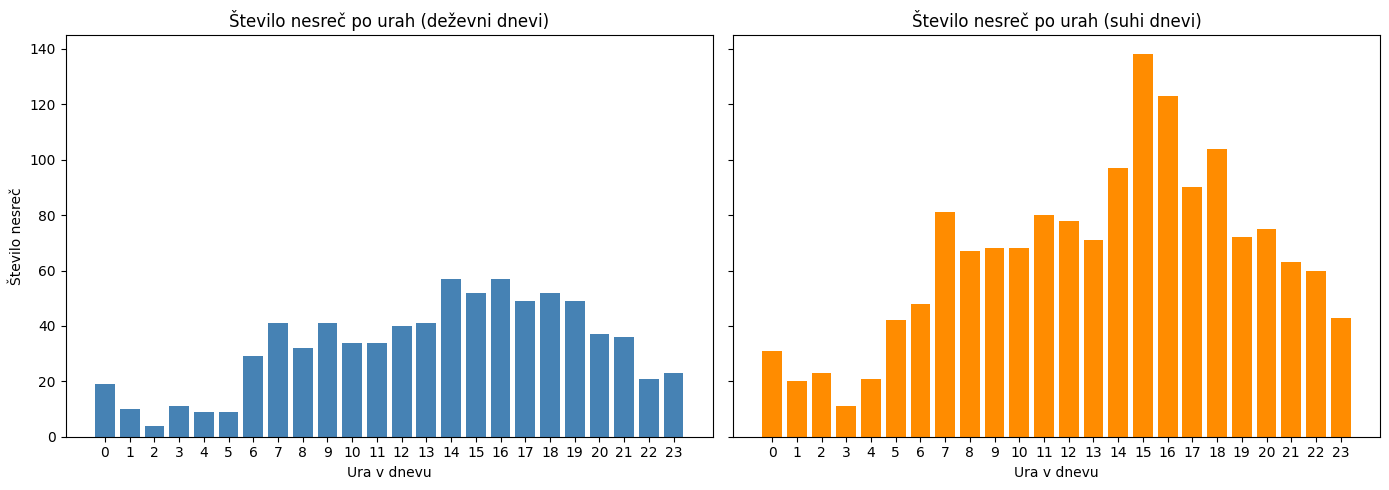

In [170]:
# Stolpčni diagram
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Deževno plot
ax1.bar(accidents_per_hour_rain.index, accidents_per_hour_rain.values, color='steelblue')
ax1.set_title("Število nesreč po urah (deževni dnevi)")
ax1.set_xlabel("Ura v dnevu")
ax1.set_ylabel("Število nesreč")
ax1.set_xticks(range(0, 24))

# Suho plot
ax2.bar(accidents_per_hour_dry.index, accidents_per_hour_dry.values, color='darkorange')
ax2.set_title("Število nesreč po urah (suhi dnevi)")
ax2.set_xlabel("Ura v dnevu")
ax2.set_xticks(range(0, 24))

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Primerjava števila nesreč po urah: deževni vs suhi dnevi')

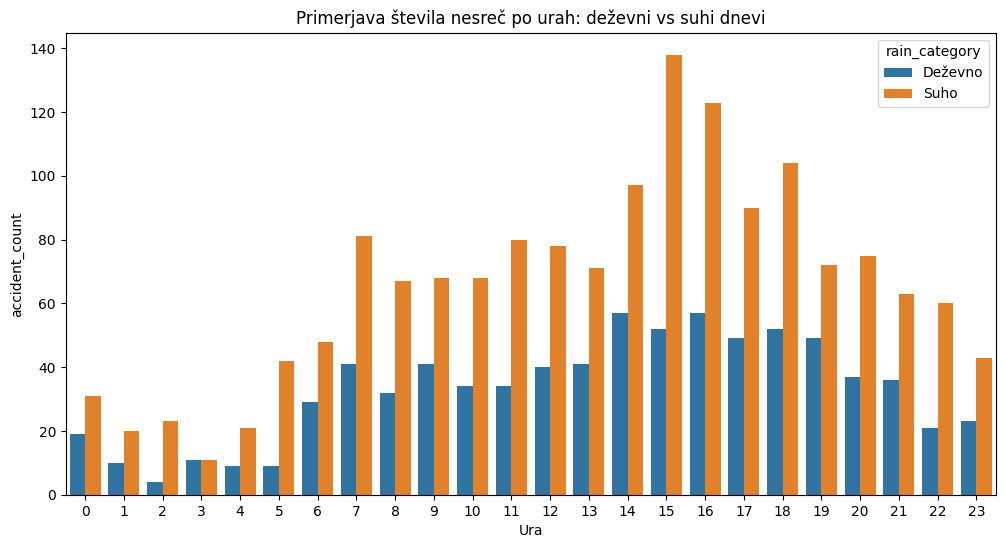

In [171]:
grouped = lj_accidents.groupby(['Ura', 'rain_category']).size().reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='Ura', y='accident_count', hue='rain_category')
plt.title('Primerjava števila nesreč po urah: deževni vs suhi dnevi')

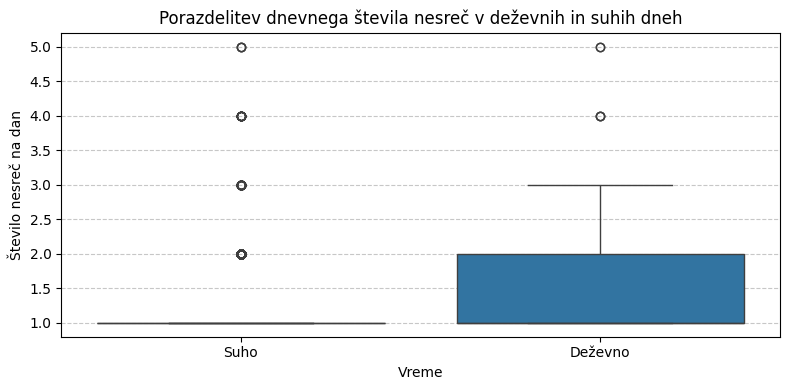

In [183]:
# BOXPLOT
# Najprej grupiram in preštejem nesreče
grouped = lj_accidents.groupby(['Datum', 'rain_category']).size()
      
# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(8, 4))
sns.boxplot(data=df_accidents, x='rain_category', y='accident_count')
plt.title('Porazdelitev dnevnega števila nesreč v deževnih in suhih dneh')
plt.xlabel('Vreme')
plt.ylabel('Število nesreč na dan')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## **Resnost posledic prometnih nesreč glede na količino padlega dežja**

Tri kategorije nesreč:
- **Nesreče brez poškodovancev**: udeleženci niso bili poškodovani in nihče ni umrl
- **Nesreče s poškodbami**: nekateri udeleženci so bili poškodovani, vendar nihče ni umrl
- **Nesreče s smrtnim izidom**: vsaj eden od udeležencev je umrl (v nesreči so bili lahko tudi drugi, ki so bili poškodovani, vendar take nesreče ne štejem v kategorijo "Nesreče s poškodbami")

## Nesreče brez poškodovancev

Text(0.5, 1.0, 'Primerjava števila nesreč brez poškodovancev po urah: deževni vs suhi dnevi')

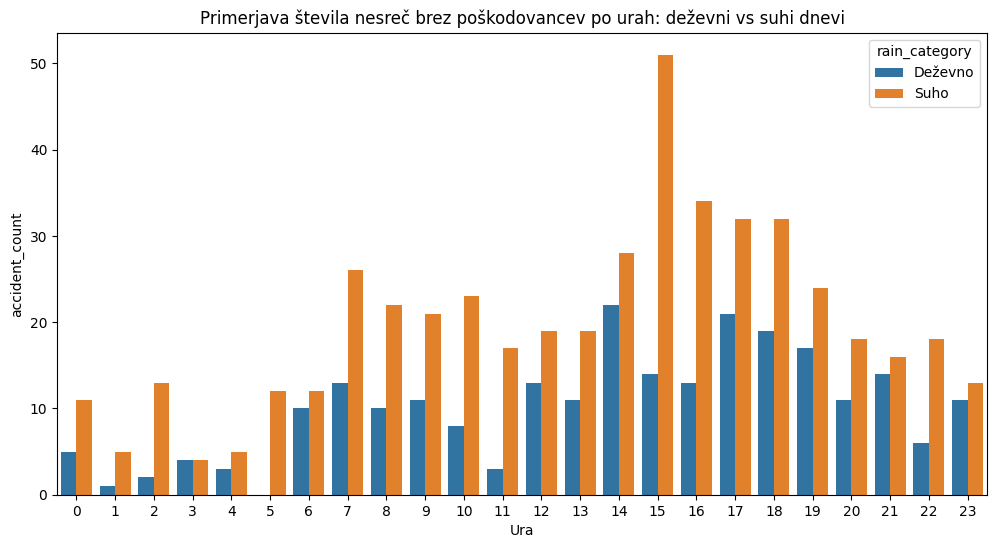

In [173]:
mask_no_injury = (lj_accidents['Severity'] == 'no_injury')
lj_accidents_no_injury = lj_accidents[mask_no_injury]

grouped = lj_accidents_no_injury.groupby(['Ura', 'rain_category']).size().reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='Ura', y='accident_count', hue='rain_category')
plt.title('Primerjava števila nesreč brez poškodovancev po urah: deževni vs suhi dnevi')

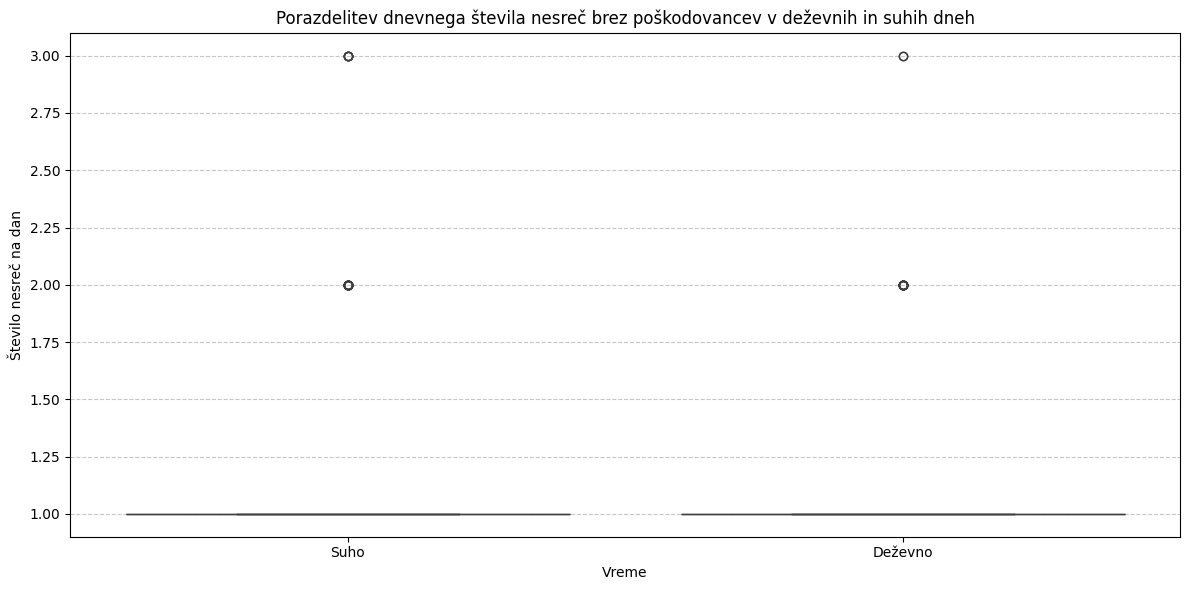

In [174]:
# BOXPLOT
# Najprej grupiram in preštejem nesreče
grouped = lj_accidents_no_injury.groupby(['Datum', 'rain_category']).size()

# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='rain_category', y='accident_count')
plt.title('Porazdelitev dnevnega števila nesreč brez poškodovancev v deževnih in suhih dneh')
plt.xlabel('Vreme')
plt.ylabel('Število nesreč na dan')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Nesreče s poškodbami

Text(0.5, 1.0, 'Primerjava števila nesreč s poškodovanci po urah: deževni vs suhi dnevi')

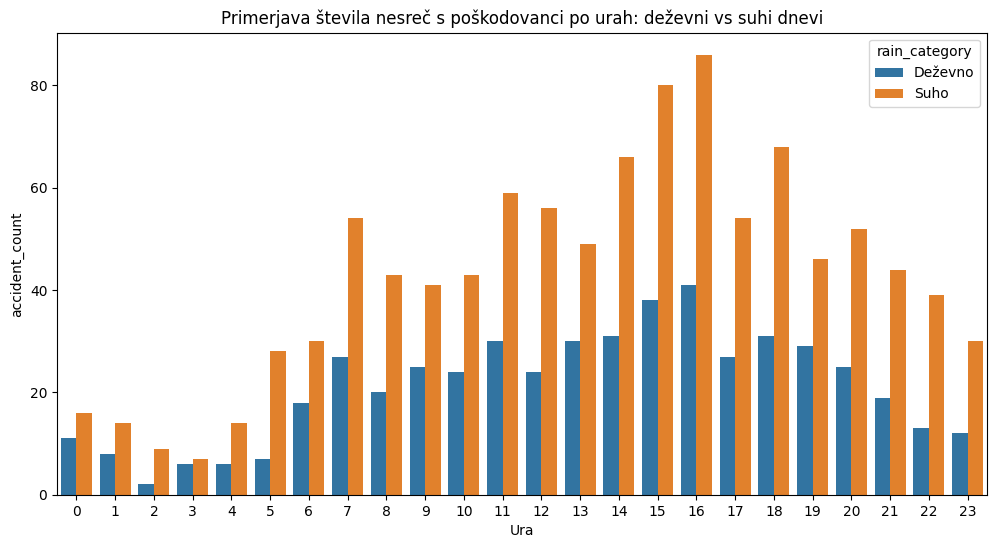

In [175]:
mask_injury = (lj_accidents['Severity'] == 'injury')
lj_accidents_injury = lj_accidents[mask_injury]

grouped = lj_accidents_injury.groupby(['Ura', 'rain_category']).size().reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='Ura', y='accident_count', hue='rain_category')
plt.title('Primerjava števila nesreč s poškodovanci po urah: deževni vs suhi dnevi')

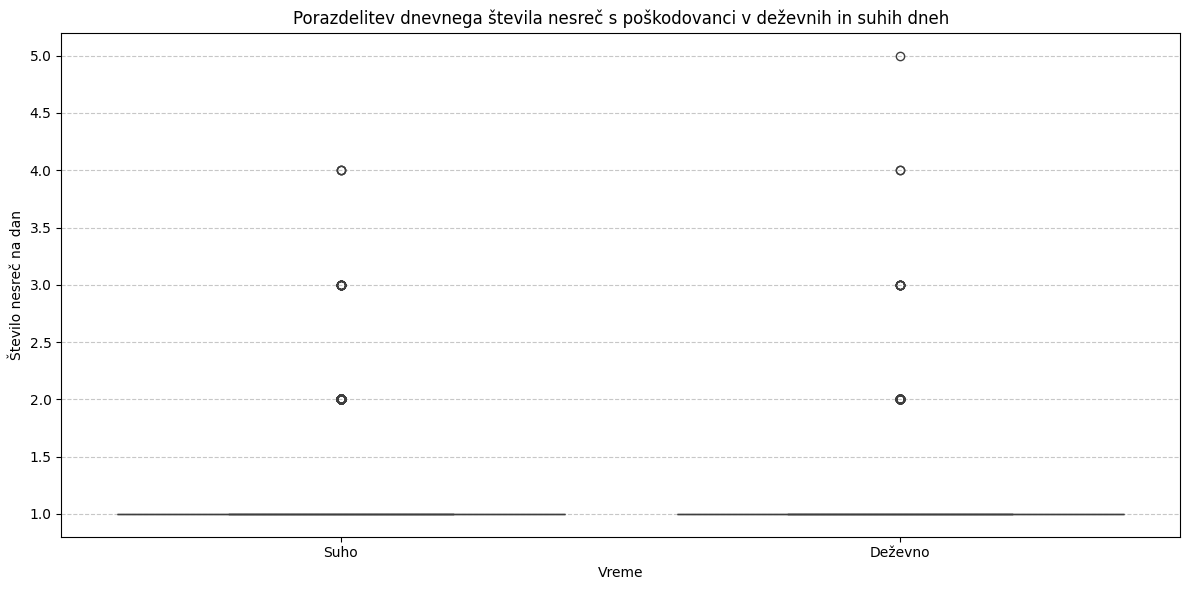

In [176]:
# BOXPLOT
# Najprej grupiram in preštejem nesreče
grouped = lj_accidents_injury.groupby(['Datum', 'rain_category']).size()

# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='rain_category', y='accident_count')
plt.title('Porazdelitev dnevnega števila nesreč s poškodovanci v deževnih in suhih dneh')
plt.xlabel('Vreme')
plt.ylabel('Število nesreč na dan')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Nesreče s smrtnim izidom

Text(0.5, 1.0, 'Primerjava števila nesreč s smrtnim izidom po urah: deževni vs suhi dnevi')

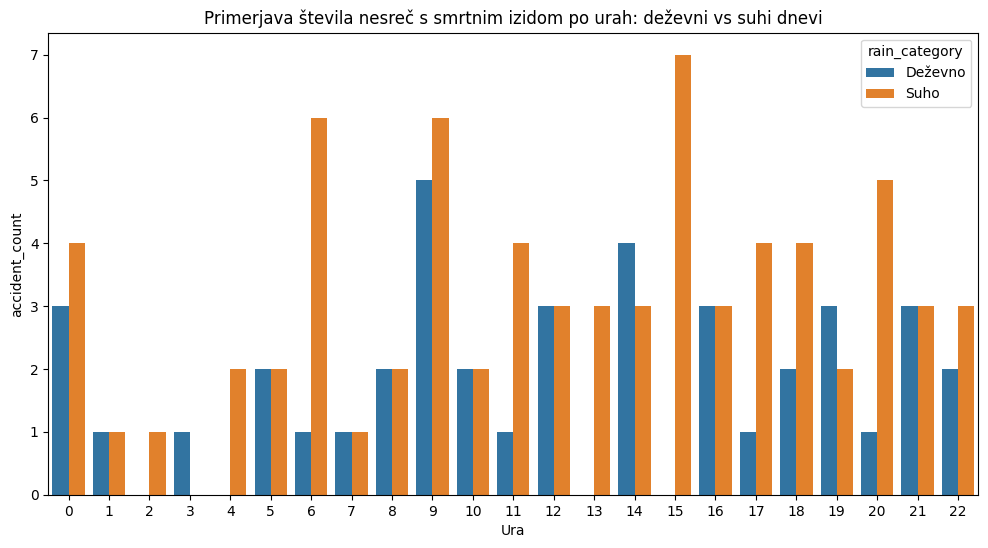

In [177]:
mask_death = (lj_accidents['Severity'] == 'death')
lj_accidents_death = lj_accidents[mask_death]

grouped = lj_accidents_death.groupby(['Ura', 'rain_category']).size().reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.barplot(data=grouped, x='Ura', y='accident_count', hue='rain_category')
plt.title('Primerjava števila nesreč s smrtnim izidom po urah: deževni vs suhi dnevi')

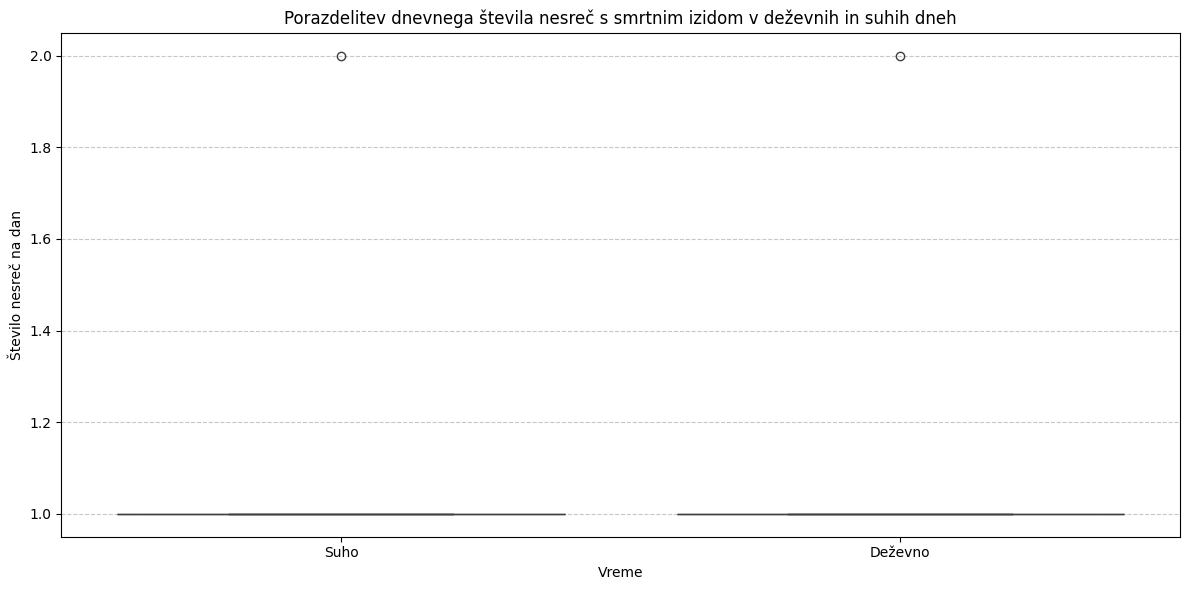

In [178]:
# BOXPLOT
# Najprej grupiram in preštejem nesreče
grouped = lj_accidents_death.groupby(['Datum', 'rain_category']).size()

# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='rain_category', y='accident_count')
plt.title('Porazdelitev dnevnega števila nesreč s smrtnim izidom v deževnih in suhih dneh')
plt.xlabel('Vreme')
plt.ylabel('Število nesreč na dan')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# **Kako količina dežja vpliva na resnost prometnih nesreč**

Kako se spreminja delež treh kategorij nesreč glede na količino zapadlega dežja.

Poglejmo, kako se resnost nesreč spreminja z dežjem - kolikšen delež nesreč je bil "resnih" v posameznem deževnem intervalu – ne le, koliko nesreč se je zgodilo.

Dež lahko spremeni vrsto nesreč, ki se zgodijo.

Od vseh nesreč, ki so se zgodile v tem deževnem intervalu, kolikšen delež nesreč je povzročil poškodbe ali smrt?


### Boxplot

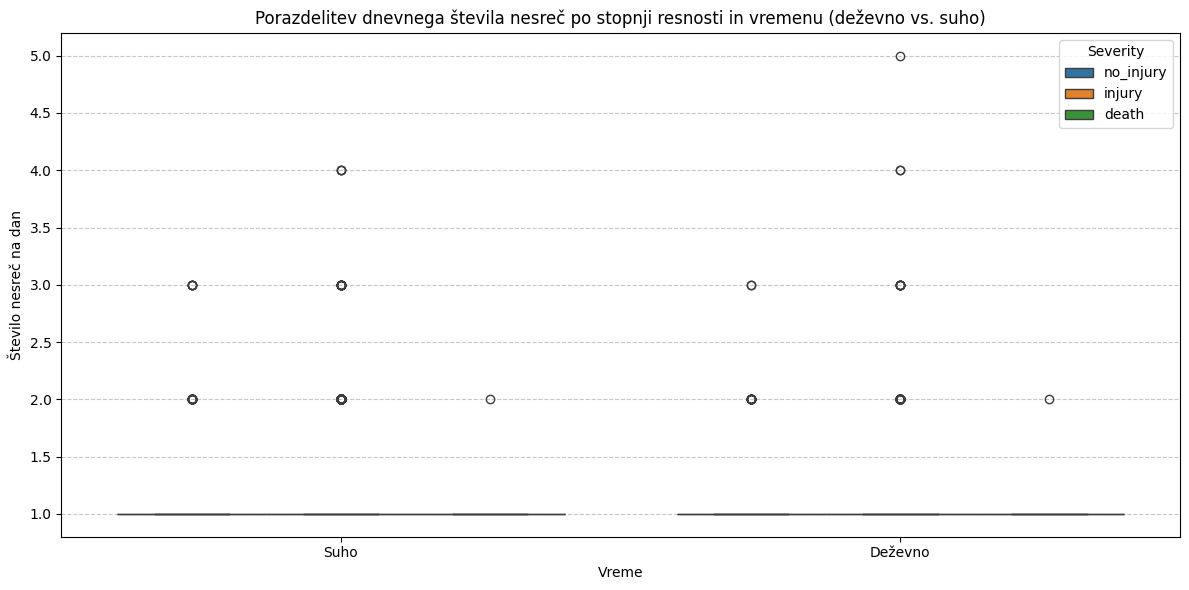

In [179]:
# Najprej grupiram in preštejem nesreče
grouped = lj_accidents.groupby(['Datum', 'rain_category', 'Severity']).size()
      
# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='rain_category', y='accident_count', hue='Severity')
plt.title('Porazdelitev dnevnega števila nesreč po stopnji resnosti in vremenu (deževno vs. suho)')
plt.xlabel('Vreme')
plt.ylabel('Število nesreč na dan')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

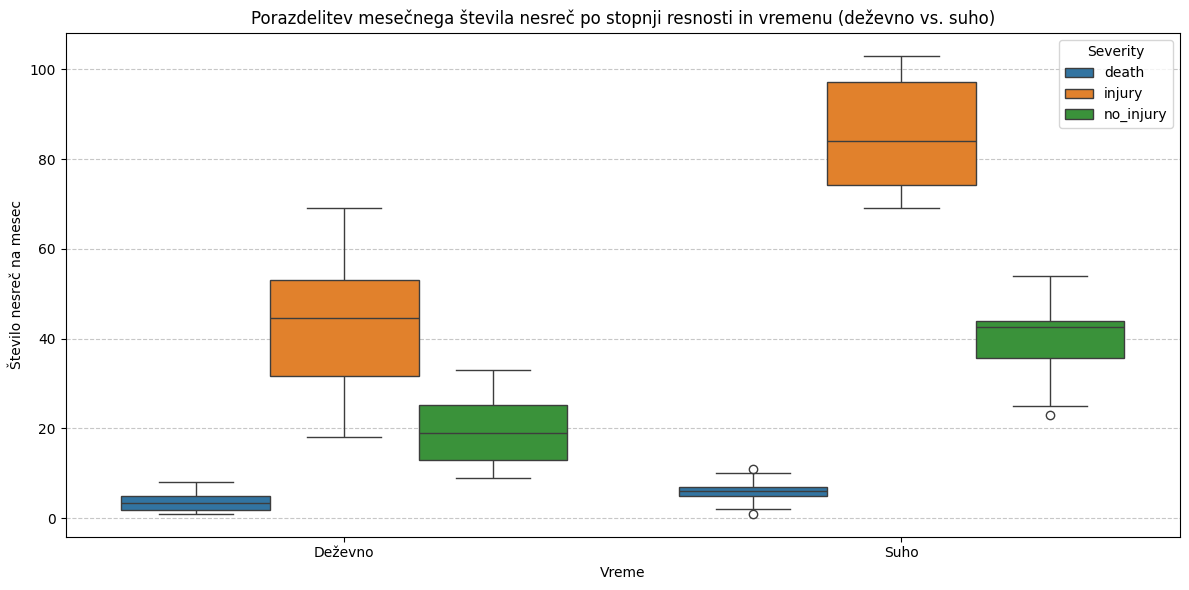

In [180]:
# Najprej grupiram in preštejem nesreče
grouped = lj_accidents.groupby(['Mesec_SLO', 'rain_category', 'Severity']).size()
      
# Rezultat grupiranja pretvorim v dataframe in stolpec s preštetimi prometnimi nesrečami poimenujem 'accident_count'
df_accidents = grouped.reset_index(name='accident_count')
# display(df_accidents)

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_accidents, x='rain_category', y='accident_count', hue='Severity')
plt.title('Porazdelitev mesečnega števila nesreč po stopnji resnosti in vremenu (deževno vs. suho)')
plt.xlabel('Vreme')
plt.ylabel('Število nesreč na mesec')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Heatmap

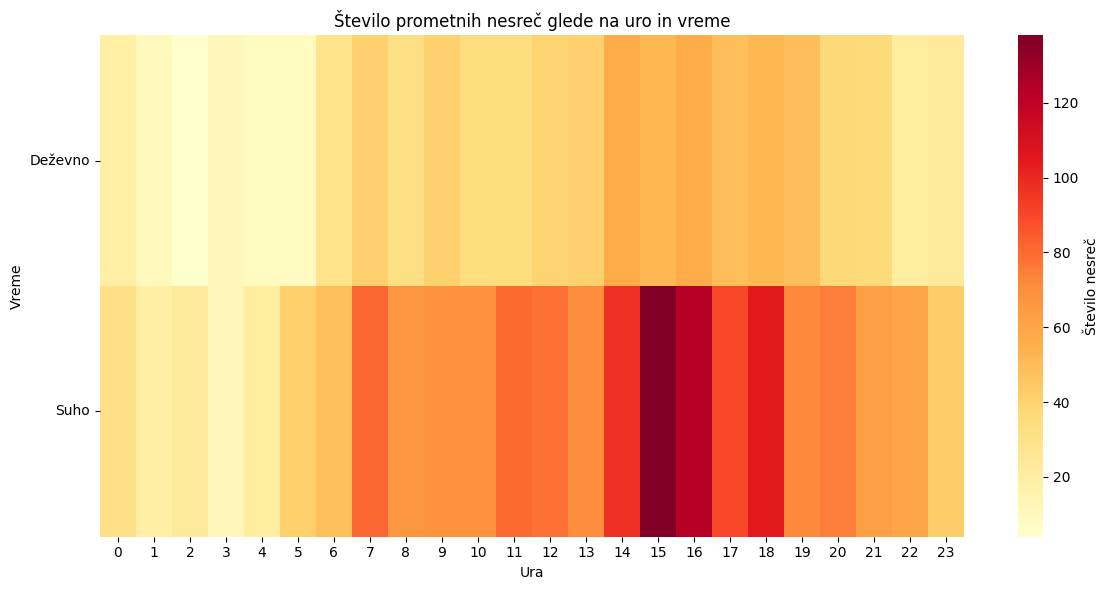

In [181]:
grouped = lj_accidents.groupby(['Ura', 'rain_category']).size()
grouped = grouped.reset_index(name='accident_count')

grouped['Ura'] = grouped['Ura'].astype(int)   # Da bodo ure smatrane kot številke in ne stringi. Da se bodo pravilno razporedile po x-osi.
# display(grouped)

df_heatmap = grouped.pivot(index='rain_category', columns='Ura', values='accident_count').fillna(0)
# display(df_heatmap)

# Heatmap
plt.figure(figsize=(12, 6))

sns.heatmap(df_heatmap, 
            annot=False,
            cmap='YlOrRd',
            cbar_kws={'label': 'Število nesreč'})
plt.xlabel('Ura')
plt.ylabel('Vreme')
plt.title('Število prometnih nesreč glede na uro in vreme')
plt.yticks(rotation=0) 
plt.tight_layout()
plt.show()

Suhih dni je več kot deževnih dni, zato bom za bolj informativen heatmap upoštevala še, število suhih in število deževnih dni.

Days per weather category: rain_category
Deževno     598
Suho       1228
dtype: int64


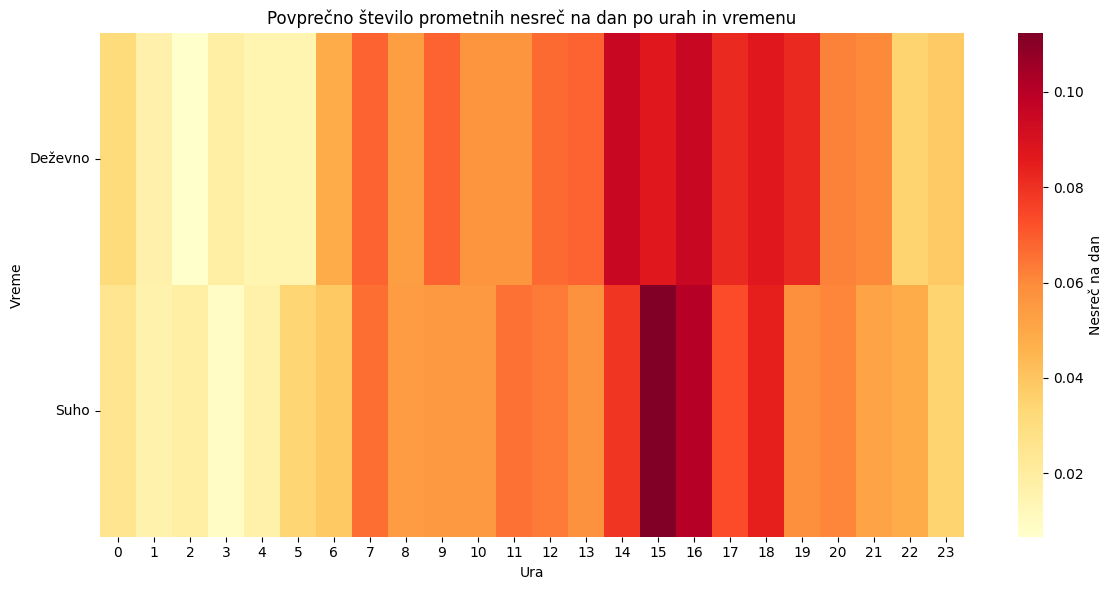

In [182]:
# Preštejem število dni za vsako kategorijo vremena
weather_days = lj_accidents.groupby(['Datum', 'rain_category']).first().groupby('rain_category').size()
print("Days per weather category:", weather_days)

# Izračunam število nesreč za vsako kombinacijo Ura-Vreme
grouped = lj_accidents.groupby(['Ura', 'rain_category']).size().reset_index(name='accident_count')
grouped['Ura'] = grouped['Ura'].astype(int)

# Izračunam povprečno število nesreč
grouped['rate_per_day'] = grouped.apply(
    lambda row: row['accident_count'] / weather_days[row['rain_category']], 
    axis=1
)

# Heatmap
df_heatmap = grouped.pivot(index='rain_category', columns='Ura', values='rate_per_day').fillna(0)

plt.figure(figsize=(12, 6))
sns.heatmap(df_heatmap, 
            annot=False,
            cmap='YlOrRd',
            cbar_kws={'label': 'Nesreč na dan'})
plt.title('Povprečno število prometnih nesreč na dan po urah in vremenu')
plt.ylabel('Vreme')
plt.xlabel('Ura')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()